# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [11]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [25]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNeXt101_32X8D_Weights.IMAGENET1K_V2
model = models.resnext101_32x8d(weights=weights)
transforms1 = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [13]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms1
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [14]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.split_ids = self.split_ids[:32]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)#/32
        #self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        num_pieces = self.num_pieces[i]

        return image, num_pieces.float()

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 32
Number of valid images: 32
Number of test images: 32


In [15]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([16, 224, 224, 3])
torch.Size([16])
tensor(1)


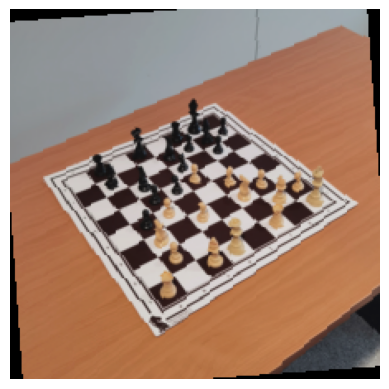

In [16]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.to(device)

Using cuda device


## Train the model

Define function to perform one iteration

In [18]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).unsqueeze(1) # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 31 + 1)#.round() # Scale [0,1] → [1,32] and round
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(scaled_pred.cpu().detach().numpy())
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
          #print(original_values)
    return total_loss / num_batches, mean_absolute_error(preds, labels)

Define function to train a model

In [19]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [20]:
# Define loss function
loss_fn = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
#optimizer = torch.optim.SGD(model.parameters(), lr=5e-5, momentum=0.9)
num_epochs = 50

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 11.50252 	 Train acc: 2.42438


100%|██████████| 137/137 [00:15<00:00,  8.72it/s]


Val loss: 2.40945 	 Val acc: 1.22187

Epoch 2


100%|██████████| 404/404 [02:11<00:00,  3.06it/s]


Train loss: 3.13540 	 Train acc: 1.38258


100%|██████████| 137/137 [00:14<00:00,  9.56it/s]


Val loss: 1.77936 	 Val acc: 1.04207

Epoch 3


100%|██████████| 404/404 [02:11<00:00,  3.06it/s]


Train loss: 2.14898 	 Train acc: 1.13738


100%|██████████| 137/137 [00:14<00:00,  9.54it/s]


Val loss: 1.73748 	 Val acc: 1.03915

Epoch 4


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 1.30391 	 Train acc: 0.88061


100%|██████████| 137/137 [00:14<00:00,  9.55it/s]


Val loss: 1.13772 	 Val acc: 0.81175

Epoch 5


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.95706 	 Train acc: 0.75608


100%|██████████| 137/137 [00:14<00:00,  9.46it/s]


Val loss: 1.25470 	 Val acc: 0.87504

Epoch 6


100%|██████████| 404/404 [02:11<00:00,  3.08it/s]


Train loss: 0.74092 	 Train acc: 0.67268


100%|██████████| 137/137 [00:14<00:00,  9.56it/s]


Val loss: 1.75722 	 Val acc: 1.06173

Epoch 7


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.58261 	 Train acc: 0.59682


100%|██████████| 137/137 [00:14<00:00,  9.56it/s]


Val loss: 0.92671 	 Val acc: 0.75168

Epoch 8


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.41976 	 Train acc: 0.50467


100%|██████████| 137/137 [00:14<00:00,  9.57it/s]


Val loss: 0.84938 	 Val acc: 0.70339

Epoch 9


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.38100 	 Train acc: 0.47991


100%|██████████| 137/137 [00:14<00:00,  9.55it/s]


Val loss: 0.80449 	 Val acc: 0.69668

Epoch 10


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.33850 	 Train acc: 0.44917


100%|██████████| 137/137 [00:14<00:00,  9.56it/s]


Val loss: 0.75302 	 Val acc: 0.66435

Epoch 11


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.31338 	 Train acc: 0.43165


100%|██████████| 137/137 [00:14<00:00,  9.57it/s]


Val loss: 0.77495 	 Val acc: 0.67618

Epoch 12


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.30808 	 Train acc: 0.42639


100%|██████████| 137/137 [00:14<00:00,  9.57it/s]


Val loss: 0.76774 	 Val acc: 0.68373

Epoch 13


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.31919 	 Train acc: 0.43521


100%|██████████| 137/137 [00:14<00:00,  9.56it/s]


Val loss: 0.70252 	 Val acc: 0.65152

Epoch 14


100%|██████████| 404/404 [02:11<00:00,  3.08it/s]


Train loss: 0.29481 	 Train acc: 0.41863


100%|██████████| 137/137 [00:14<00:00,  9.57it/s]


Val loss: 0.86163 	 Val acc: 0.73788

Epoch 15


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.29171 	 Train acc: 0.41078


100%|██████████| 137/137 [00:14<00:00,  9.53it/s]


Val loss: 0.65909 	 Val acc: 0.62831

Epoch 16


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.31694 	 Train acc: 0.42935


100%|██████████| 137/137 [00:14<00:00,  9.56it/s]


Val loss: 0.81254 	 Val acc: 0.70678

Epoch 17


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.30349 	 Train acc: 0.42028


100%|██████████| 137/137 [00:14<00:00,  9.57it/s]


Val loss: 0.68415 	 Val acc: 0.63544

Epoch 18


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.24848 	 Train acc: 0.37839


100%|██████████| 137/137 [00:14<00:00,  9.54it/s]


Val loss: 0.68042 	 Val acc: 0.62553

Epoch 19


100%|██████████| 404/404 [02:11<00:00,  3.07it/s]


Train loss: 0.23889 	 Train acc: 0.37058


100%|██████████| 137/137 [00:14<00:00,  9.56it/s]


Val loss: 0.87158 	 Val acc: 0.71802

Epoch 20


100%|██████████| 404/404 [02:14<00:00,  2.99it/s]


Train loss: 0.22654 	 Train acc: 0.35825


100%|██████████| 137/137 [00:14<00:00,  9.28it/s]


Val loss: 0.64470 	 Val acc: 0.61009

Epoch 21


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 0.20396 	 Train acc: 0.34253


100%|██████████| 137/137 [00:14<00:00,  9.19it/s]


Val loss: 0.57485 	 Val acc: 0.57983

Epoch 22


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 0.17931 	 Train acc: 0.32095


100%|██████████| 137/137 [00:14<00:00,  9.19it/s]


Val loss: 0.59420 	 Val acc: 0.59392

Epoch 23


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 0.17021 	 Train acc: 0.31388


100%|██████████| 137/137 [00:14<00:00,  9.25it/s]


Val loss: 0.60302 	 Val acc: 0.58953

Epoch 24


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 0.17560 	 Train acc: 0.31529


100%|██████████| 137/137 [00:14<00:00,  9.19it/s]


Val loss: 0.67438 	 Val acc: 0.61933

Epoch 25


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 0.22118 	 Train acc: 0.35155


100%|██████████| 137/137 [00:14<00:00,  9.26it/s]


Val loss: 0.55246 	 Val acc: 0.56403

Epoch 26


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 0.19305 	 Train acc: 0.32886


100%|██████████| 137/137 [00:14<00:00,  9.25it/s]


Val loss: 0.61092 	 Val acc: 0.58585

Epoch 27


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 0.18211 	 Train acc: 0.32086


100%|██████████| 137/137 [00:14<00:00,  9.32it/s]


Val loss: 0.53821 	 Val acc: 0.56275

Epoch 28


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 0.18326 	 Train acc: 0.32399


100%|██████████| 137/137 [00:14<00:00,  9.23it/s]


Val loss: 0.61404 	 Val acc: 0.59486

Epoch 29


100%|██████████| 404/404 [02:16<00:00,  2.96it/s]


Train loss: 0.16398 	 Train acc: 0.30772


100%|██████████| 137/137 [00:14<00:00,  9.27it/s]


Val loss: 0.50366 	 Val acc: 0.53014

Epoch 30


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 0.14294 	 Train acc: 0.28532


100%|██████████| 137/137 [00:14<00:00,  9.24it/s]


Val loss: 0.67632 	 Val acc: 0.64400

Epoch 31


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 0.13343 	 Train acc: 0.27482


100%|██████████| 137/137 [00:14<00:00,  9.15it/s]


Val loss: 0.49964 	 Val acc: 0.53986

Epoch 32


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 0.12690 	 Train acc: 0.26812


100%|██████████| 137/137 [00:14<00:00,  9.27it/s]


Val loss: 0.52370 	 Val acc: 0.55856

Epoch 33


100%|██████████| 404/404 [02:16<00:00,  2.97it/s]


Train loss: 0.12307 	 Train acc: 0.26343


100%|██████████| 137/137 [00:14<00:00,  9.78it/s]


Val loss: 0.46715 	 Val acc: 0.51655

Epoch 34


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 0.12101 	 Train acc: 0.25800


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 0.50741 	 Val acc: 0.53916

Epoch 35


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 0.12720 	 Train acc: 0.26557


100%|██████████| 137/137 [00:14<00:00,  9.71it/s]


Val loss: 0.50903 	 Val acc: 0.53452

Epoch 36


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 0.15650 	 Train acc: 0.29509


100%|██████████| 137/137 [00:14<00:00,  9.78it/s]


Val loss: 0.50970 	 Val acc: 0.54176

Epoch 37


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 0.13689 	 Train acc: 0.27754


100%|██████████| 137/137 [00:14<00:00,  9.78it/s]


Val loss: 0.53929 	 Val acc: 0.54635

Epoch 38


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 0.11435 	 Train acc: 0.25230


100%|██████████| 137/137 [00:13<00:00,  9.79it/s]


Val loss: 0.46312 	 Val acc: 0.50771

Epoch 39


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 0.10256 	 Train acc: 0.23840


100%|██████████| 137/137 [00:14<00:00,  9.78it/s]


Val loss: 0.46054 	 Val acc: 0.51291

Epoch 40


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 0.11147 	 Train acc: 0.24941


100%|██████████| 137/137 [00:14<00:00,  9.77it/s]


Val loss: 0.54590 	 Val acc: 0.55504

Epoch 41


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 0.09977 	 Train acc: 0.23700


100%|██████████| 137/137 [00:14<00:00,  9.78it/s]


Val loss: 0.48050 	 Val acc: 0.52394

Epoch 42


100%|██████████| 404/404 [02:09<00:00,  3.13it/s]


Train loss: 0.08383 	 Train acc: 0.21651


100%|██████████| 137/137 [00:14<00:00,  9.78it/s]


Val loss: 0.51270 	 Val acc: 0.55219

Epoch 43


100%|██████████| 404/404 [02:15<00:00,  2.99it/s]


Train loss: 0.09677 	 Train acc: 0.23243


100%|██████████| 137/137 [00:14<00:00,  9.14it/s]


Val loss: 0.48204 	 Val acc: 0.53436

Epoch 44


100%|██████████| 404/404 [02:18<00:00,  2.91it/s]


Train loss: 0.10501 	 Train acc: 0.24293


100%|██████████| 137/137 [00:14<00:00,  9.15it/s]


Val loss: 0.46240 	 Val acc: 0.51677

Epoch 45


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 0.12146 	 Train acc: 0.25753


100%|██████████| 137/137 [00:14<00:00,  9.25it/s]


Val loss: 0.51730 	 Val acc: 0.54196

Epoch 46


100%|██████████| 404/404 [02:18<00:00,  2.92it/s]


Train loss: 0.10542 	 Train acc: 0.24161


100%|██████████| 137/137 [00:15<00:00,  8.72it/s]


Val loss: 0.44452 	 Val acc: 0.50062

Epoch 47


100%|██████████| 404/404 [02:17<00:00,  2.95it/s]


Train loss: 0.08634 	 Train acc: 0.21894


100%|██████████| 137/137 [00:14<00:00,  9.61it/s]


Val loss: 0.50640 	 Val acc: 0.54403

Epoch 48


100%|██████████| 404/404 [02:16<00:00,  2.95it/s]


Train loss: 0.07884 	 Train acc: 0.20915


100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


Val loss: 0.47217 	 Val acc: 0.51935

Epoch 49


100%|██████████| 404/404 [02:15<00:00,  2.98it/s]


Train loss: 0.07576 	 Train acc: 0.20219


100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


Val loss: 0.44603 	 Val acc: 0.50364

Epoch 50


100%|██████████| 404/404 [02:17<00:00,  2.94it/s]


Train loss: 0.07653 	 Train acc: 0.20617


100%|██████████| 137/137 [00:14<00:00,  9.22it/s]


Val loss: 0.47589 	 Val acc: 0.51710
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [21]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

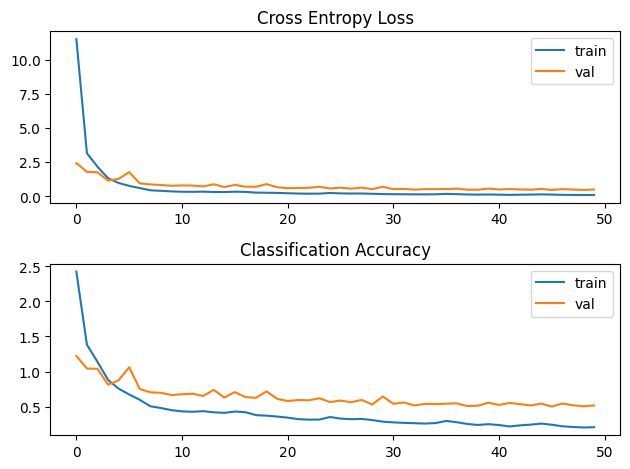

In [22]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [ ]:
# Load the best model
# TODO
#test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, drop_last=False)
#print(torch.load('chess_model_best_model.pth')['model'])
# 1. First create the model with the EXACT same architecture used during training
from sklearn.metrics import mean_absolute_error,mean_squared_error
weights = models.ResNeXt101_32X8D_Weights.IMAGENET1K_V2
transforms1 = weights.transforms()
model = models.resnext101_32x8d(weights=None)  # Don't load ImageNet weights for fine-tuned model

# 2. Recreate your custom head EXACTLY as during training
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

# 3. Load the state dict
checkpoint = torch.load('chess_model_best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model'])  # Correct way to load state dict

# 4. Prepare for evaluation
model = model.to(device)
model.eval()
# Evaluate model on test data
# TODO
def test(dataloader):
    preds = []
    labels = []
    with torch.set_grad_enabled(False):
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = pred.cpu().detach().numpy()*32
            preds.extend(predsTmp)
            #print(pred.cpu())
            #print(y.cpu())
            original_values =y.cpu()
            labels.extend(original_values)
            #print(original_values)
        return mean_absolute_error(preds, labels)
test_loss = test(test_dataloader)
# load data transformed with
#data =[(img,count pieces),...]
#data =
print(f"mean absolute error : {test_loss:.3f}")

SyntaxError: invalid syntax (3280523336.py, line 51)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?